#Pre-requisites

In [ ]:
# install pnslib
!pip install git+git://github.com/PnS2019/pnslib.git

!pip install mtcnn

  Cloning git://github.com/PnS2019/pnslib.git to /tmp/pip-req-build-oxdi5zfm
  Running command git clone -q git://github.com/PnS2019/pnslib.git /tmp/pip-req-build-oxdi5zfm
  Created wheel for pnslib: filename=pnslib-0.1.0a1-cp36-none-any.whl size=1489618 sha256=1bba22ec3d46ef0cca7ecbf16efdc2a6ace5690ccdde38b4c3cbdaec33ad17f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ri4tpj6/wheels/a2/8e/a9/c62e72840009deaa723b3a113d5c3b90acac77098d16e90eca
Successfully built pnslib


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import load_model
from tensorflow.keras import Input

from pnslib import utils
from google.colab.patches import cv2_imshow 

import mtcnn
print(mtcnn.__version__)

from mtcnn.mtcnn import MTCNN

%matplotlib inline

0.1.0


In [ ]:
ALPHA = 0.5
THRESHOLD = 0.5
IMAGE_SIZE= 160
LAYERS_TO_FREEZE= 60
NUM_EPOCHS= 1
STEPS_PER_EPOCH= 1
BATCH_SIZE= 16

input_shape = (IMAGE_SIZE, IMAGE_SIZE , 3)

#Datasets Paths


In [ ]:
paths = {}
Ben_base = '/content/drive/My Drive/Colab Notebooks/Anti-COVIDNET/Dataset/Ben'
paths["Ben"] = [os.path.join(Ben_base,img_path) for img_path in os.listdir(Ben_base)]

Chris_base = '/content/drive/My Drive/Colab Notebooks/Anti-COVIDNET/Dataset/Chris'
paths["Chris"] = [os.path.join(Chris_base,img_path) for img_path in os.listdir(Chris_base)]

Henry_base = '/content/drive/My Drive/Colab Notebooks/Anti-COVIDNET/Dataset/Henry'
paths["Henry"] = [os.path.join(Henry_base,img_path) for img_path in os.listdir(Henry_base)]

Robert_base = '/content/drive/My Drive/Colab Notebooks/Anti-COVIDNET/Dataset/Robert'
paths["Robert"] = [os.path.join(Robert_base,img_path) for img_path in os.listdir(Robert_base)]

Tom_base = '/content/drive/My Drive/Colab Notebooks/Anti-COVIDNET/Dataset/Tom'
paths["Tom"] = [os.path.join(Tom_base,img_path) for img_path in os.listdir(Tom_base)]

paths_copy = paths.copy()

for key in paths.keys():
    if paths[key] == []:
        del paths_copy[key]

paths = paths_copy
del paths_copy

In [ ]:
print(paths.keys())

dict_keys(['Ben', 'Chris', 'Henry', 'Robert', 'Tom'])


#Facenet Model

In [ ]:
# load the facenet model
facenet_model = load_model('/content/drive/My Drive/Colab Notebooks/Anti-COVIDNET/Facenet/Copy of facenet_keras.h5')
print('Loaded Model')
facenet_model.load_weights('/content/drive/My Drive/Colab Notebooks/Anti-COVIDNET/Facenet/Copy of facenet_keras_weights.h5')
print('Weights loaded')

In [ ]:
facenet_model.summary()

for layer in facenet_model.layers:
    layer.trainable = False

#Detect and Extract Faces

In [ ]:
detector = MTCNN()

def detect_face (img):
    if img.shape[0] > (IMAGE_SIZE + 10) and img.shape[1] > (IMAGE_SIZE + 10):
        # detect faces in the image
        results = detector.detect_faces(img)
        # extract the bounding box from the first face
        x1, y1, width, height = results[0]['box']
        # deal with negative pixel index
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        # extract the face
        img = img[y1:y2 , x1:x2]
    return img

(227, 222, 3)
(160, 160, 3)


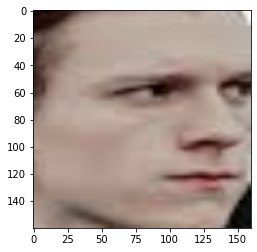

In [ ]:
#testing detect face function
image = cv2.imread(paths["Tom"][3])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
print(image.shape)
img = detect_face(image)
img = cv2.resize(img , (IMAGE_SIZE , IMAGE_SIZE))
plt.imshow(img)
print(img.shape)
del image
del img

#Pre-processing part and Image Dictionary

In [ ]:
def pre_process(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img  = detect_face(image)
    img = cv2.resize(img , (IMAGE_SIZE , IMAGE_SIZE))   
    #img = np.around(img / 255.0, decimals=12)           # normalize upto 12 decimals
    assert img.shape == input_shape  
    del image  
    return img


In [ ]:
images = {}
for (name,img_paths) in paths.items():
    print(name)
    images[name] = [pre_process(path) for path in img_paths]
    print("Done with" + name)

Ben
Done withBen
Chris
Done withChris
Henry
Done withHenry
Robert
Done withRobert
Tom
Done withTom


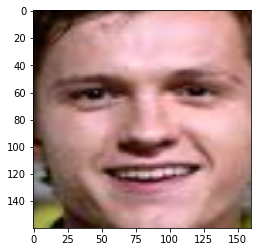

In [ ]:
plt.imshow(images["Tom"][0])

#Image to Embeddings and Embeddings Dictionary

In [ ]:
def get_embedding(model, image):
    # scale pixel values
    image = image.astype('float32')
    # standardization
    mean, std = image.mean(), image.std()
    image = (image-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(image, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    del image
    del sample
    return yhat[0]

In [ ]:
embeddings = {}
for (name,img_arrays) in images.items():
    print(name)
    embeddings[name] = [get_embedding(facenet_model , image) for image in img_arrays]
    print("Done with " + name)

Ben
Done with Ben
Chris
Done with Chris
Henry
Done with Henry
Robert
Done with Robert
Tom
Done with Tom


In [ ]:
embeddings["Ben"][0].shape

(128,)

#Testing


In [ ]:
def who_is_it(image_pred, database, model):
   
    encoding = get_embedding(model , image_pred)
    
    min_dist = 10000
    
    for (name, db_emb) in database.items():
        for emb in db_emb:
            dist =  np.linalg.norm(encoding - emb , ord = 2)   # L2 distnce
            if dist < min_dist:
                min_dist = dist
                identity = name
    
    if min_dist > 10:
        print("Not in the database. Distance: " + str(min_dist))
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
    
    del encoding
    return min_dist,identity

In [ ]:
check = who_is_it(images["Robert"][1], embeddings, facenet_model)

it's Robert, the distance is 0.0


it's Chris, the distance is 7.4393263


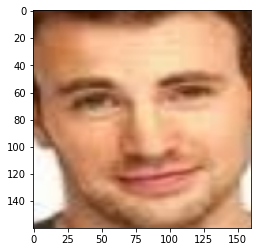

In [ ]:
test_image = pre_process('/content/drive/My Drive/Colab Notebooks/Anti-COVIDNET/test_dataset/chris7.jfif')
plt.imshow(test_image)
check = who_is_it(test_image, embeddings, facenet_model)